# IMDb Top-250: анализ лучших фильмов

**Описание проекта**

Мы берём список *IMDb Top-250* с официального сайта, автоматически
скачиваем данные о каждом фильме, очищаем их и анализируем:

* распределение рейтингов и голосов,
* какие жанры, годы и страны доминируют,
* как связаны рейтинг, число голосов и длительность,
* кто из актёров встречается чаще всего.

В ноутбуке покажем **полный путь**:  
скрейпинг → очистка → EDA → выводы.

In [17]:
import json
import os
import re
import sys
import time

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [5]:
# ─────────────────────────────────────────────────────────────
# Настройки
URL = "https://www.imdb.com/chart/top"
HEADERS = {"User-Agent": "Mozilla/5.0"}


# ─────────────────────────────────────────────────────────────
# Парсим длительность из формата "PT2H22M" → 142 (минуты)
def parse_duration(duration_str):
    match = re.match(r"PT(?:(\d+)H)?(?:(\d+)M)?", duration_str or "")
    if not match:
        return None
    hours = int(match.group(1) or 0)
    minutes = int(match.group(2) or 0)
    return hours * 60 + minutes


# ─────────────────────────────────────────────────────────────
# Получаем дополнительные данные из карточки фильма
def get_details_from_card(url):
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")

        # JSON‑LD блок с актёрами и датой выхода
        json_ld = soup.find("script", type="application/ld+json")
        data = json.loads(json_ld.string) if json_ld else {}

        # Год выхода
        year = int(data["datePublished"][:4]) if "datePublished" in data else None

        # Страна производства (берём первую)
        country_tag = soup.find("a", href=re.compile(r"/search/title/\?country_of_origin="))
        country = country_tag.text.strip() if country_tag else None

        # Ведущие актёры (до 5 имён)
        actors_data = data.get("actor", [])
        actors = [actor.get("name") for actor in actors_data[:5]]
        actors_str = ", ".join(actors) if actors else None

        return year, country, actors_str

    except Exception as e:
        print(f"[!] Ошибка при парсинге карточки {url}: {e}")
        return None, None, None


# ─────────────────────────────────────────────────────────────
# Основной парсинг IMDb Top‑250
def fetch_top250(deep=False, delay=0.05):
    print("Скачиваем список фильмов…")
    response = requests.get(URL, headers=HEADERS, timeout=10)
    soup = BeautifulSoup(response.text, "html.parser")

    json_block = soup.find("script", type="application/ld+json")
    items = json.loads(json_block.string)["itemListElement"]

    movies = []
    total = len(items)

    for index, item in enumerate(items, start=1):
        movie_data = item["item"]
        movie_url = (
            "https://www.imdb.com" + movie_data["url"]
            if movie_data["url"].startswith("/")
            else movie_data["url"]
        )

        movie = {
            "rank": index,
            "title": movie_data.get("name"),
            "rating": float(movie_data["aggregateRating"]["ratingValue"]),
            "votes": int(movie_data["aggregateRating"]["ratingCount"]),
            "genres": (
                ", ".join(movie_data["genre"])
                if isinstance(movie_data.get("genre"), list)
                else movie_data.get("genre", "")
            ),
            "duration_min": parse_duration(movie_data.get("duration")),
            "content_rating": movie_data.get("contentRating"),
            "year": None,
            "country": None,
            "actors": None,
            "url": movie_url,
        }

        if deep:
            try:
                year, country, actors = get_details_from_card(movie_url)
                movie.update({"year": year, "country": country, "actors": actors})
                print(f"[{index:3}/{total}] {movie['title']} — ok")
            except Exception as e:
                print(f"[{index:3}/{total}] {movie['title']} — ошибка: {e}")
            time.sleep(delay)

        movies.append(movie)

    return pd.DataFrame(movies)


# ─────────────────────────────────────────────────────────────
# Сохраняем результат в CSV
def save_csv(df, deep):
    filename = "imdb_top250_full.csv" if deep else "imdb_top250_basic.csv"
    path = os.path.join("..", "data", "raw", filename)

    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False, encoding="utf-8")

    print(f"\nСохранено {len(df)} фильмов в → {path}")


# ─────────────────────────────────────────────────────────────
# Точка входа
def main():
    deep_mode = True
    df = fetch_top250(deep=deep_mode)
    save_csv(df, deep=deep_mode)


if __name__ == "__main__":
    main()

Скачиваем список фильмов…
[  1/250] The Shawshank Redemption — ok
[  2/250] The Godfather — ok
[  3/250] The Dark Knight — ok
[  4/250] The Godfather Part II — ok
[  5/250] 12 Angry Men — ok
[  6/250] The Lord of the Rings: The Return of the King — ok
[  7/250] Schindler&apos;s List — ok
[  8/250] Pulp Fiction — ok
[  9/250] The Lord of the Rings: The Fellowship of the Ring — ok
[ 10/250] Il buono, il brutto, il cattivo — ok
[ 11/250] Forrest Gump — ok
[ 12/250] The Lord of the Rings: The Two Towers — ok
[ 13/250] Fight Club — ok
[ 14/250] Inception — ok
[ 15/250] Star Wars: Episode V - The Empire Strikes Back — ok
[ 16/250] The Matrix — ok
[ 17/250] GoodFellas — ok
[ 18/250] Interstellar — ok
[ 19/250] One Flew Over the Cuckoo&apos;s Nest — ok
[ 20/250] Se7en — ok
[ 21/250] It&apos;s a Wonderful Life — ok
[ 22/250] The Silence of the Lambs — ok
[ 23/250] Shichinin no samurai — ok
[ 24/250] Saving Private Ryan — ok
[ 25/250] Cidade de Deus — ok
[ 26/250] The Green Mile — ok
[ 27/250] L

## Очистка данных и подготовка к анализу

In [6]:
"""
Очистка сырых CSV из папки data/raw/ и сохранение чистых версий в data/clean/.

Запускать после парсинга фильмов:
    python scripts/clean_imdb_top250.py
"""

# ───────────────────────────────────────────────
# Пути к папкам
RAW_DIR = os.path.join("..", "data", "raw")
CLEAN_DIR = os.path.join("..", "data", "clean")

# Названия входных и выходных файлов
FILES = {
    "imdb_top250_basic.csv": "imdb_top250_basic_clean.csv",
    "imdb_top250_full.csv":  "imdb_top250_full_clean.csv",
}

# ───────────────────────────────────────────────
# Очистка одного датафрейма
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Приводим типы, убираем дубликаты и пропуски, genres и actors → список."""

    # Приведение типов: числовые
    for col in ["rank", "rating", "votes", "duration_min"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Приведение года к int (без .0)
    if "year" in df.columns:
        df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    # genres: строка → список
    if "genres" in df.columns:
        df["genres"] = df["genres"].fillna("").apply(
            lambda x: [g.strip() for g in x.split(",")] if x else []
        )

    # actors: строка → список
    if "actors" in df.columns:
        df["actors"] = df["actors"].fillna("").apply(
            lambda x: [a.strip() for a in x.split(",")] if x else []
        )

    # Удаляем дубликаты по url
    if "url" in df.columns:
        df = df.drop_duplicates(subset="url")

    # Удаляем строки без названия или рейтинга
    df = df.dropna(subset=["title", "rating"])

    return df.reset_index(drop=True)

# ───────────────────────────────────────────────
# Основной процесс
def main():
    os.makedirs(CLEAN_DIR, exist_ok=True)

    for raw_name, clean_name in FILES.items():
        raw_path = os.path.join(RAW_DIR, raw_name)
        clean_path = os.path.join(CLEAN_DIR, clean_name)

        if not os.path.isfile(raw_path):
            print(f"[!] Файл не найден: {raw_path} — пропускаем.")
            continue

        print(f"→ Обрабатываем: {raw_name}")
        df_raw = pd.read_csv(raw_path)
        df_clean = clean_dataframe(df_raw)
        df_clean.to_csv(clean_path, index=False, encoding="utf-8")
        print(f"✓ Сохранено: {clean_name} ({len(df_clean)} строк)\n")

# ───────────────────────────────────────────────
if __name__ == "__main__":
    main()

→ Обрабатываем: imdb_top250_basic.csv
✓ Сохранено: imdb_top250_basic_clean.csv (250 строк)

→ Обрабатываем: imdb_top250_full.csv
✓ Сохранено: imdb_top250_full_clean.csv (250 строк)



## Очистка данных и предварительный анализ

На этом этапе мы изучим, какие переменные доступны в датасете IMDb Top‑250, есть ли пропущенные значения и как распределены ключевые числовые признаки.  
Также рассмотрим частотность жанров и стран производства, чтобы лучше понять структуру выборки и сформулировать гипотезы для дальнейшего анализа.

✅ Загружено 250 фильмов
🗒️  Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rank            250 non-null    int64  
 1   title           250 non-null    object 
 2   rating          250 non-null    float64
 3   votes           250 non-null    int64  
 4   genres          250 non-null    object 
 5   duration_min    250 non-null    int64  
 6   content_rating  245 non-null    object 
 7   year            249 non-null    float64
 8   country         250 non-null    object 
 9   actors          250 non-null    object 
 10  url             250 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 21.6+ KB

❓ Пропуски в столбцах:


,rank,title,rating,votes,genres,duration_min,content_rating,year,country,actors,url
missing,0,0,0,0,0,0,5,1,0,0,0



📊 Описательная статистика числовых признаков:


,count,mean,std,min,25%,50%,75%,max
rank,250.0,125.500000,72.312977,1.0,63.25,125.5,187.75,250.0
rating,250.0,8.308400,0.232607,8.0,8.10,8.2,8.40,9.3
votes,250.0,732637.516000,590890.624191,26438.0,242595.75,611338.5,1074102.75,3043225.0
duration_min,250.0,130.700000,32.196342,45.0,109.00,128.0,147.00,321.0
year,249.0,1988.859438,25.398762,1921.0,1973.00,1996.0,2009.00,2025.0


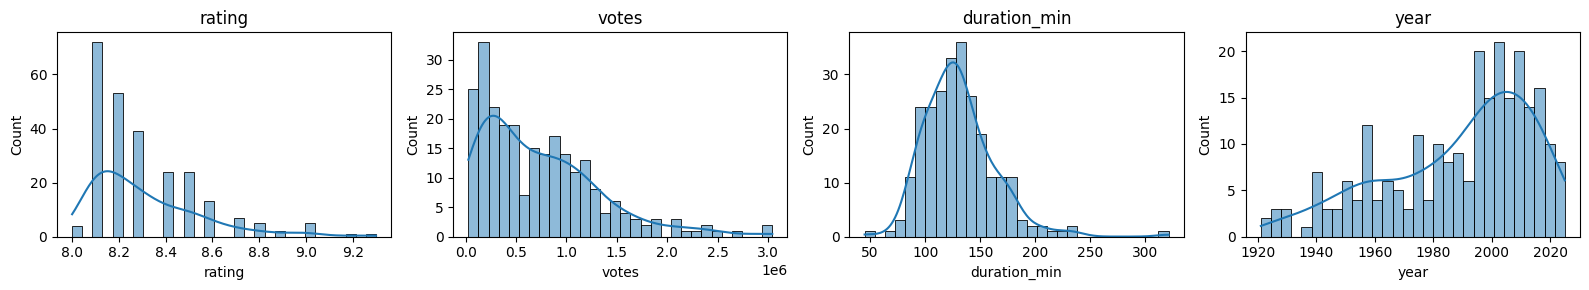


🎬 Топ-10 жанров:


,count
genres,
['Drama'],17
"['Crime', 'Drama']",13
"['Biography', 'Drama', 'History']",9
"['Crime', 'Drama', 'Mystery']",9
"['Drama', 'War']",8
"['Animation', 'Adventure', 'Comedy']",8
"['Action', 'Adventure', 'Sci-Fi']",7
"['Crime', 'Drama', 'Thriller']",6
"['Comedy', 'Drama']",6



🌍 Топ-10 стран-производителей:


,count
country,
United States,150
United Kingdom,26
Japan,15
France,8
Italy,8
India,7
Germany,6
South Korea,4
New Zealand,3


In [14]:
# путь к очищенному датасету (проверь, что папка/файл совпадают с твоими)
DATA_PATH = "../data/clean/imdb_top250_full_clean.csv"

if not os.path.isfile(DATA_PATH):
    raise FileNotFoundError(
        f"Файл {DATA_PATH} не найден. "
        "Сначала запусти get_imdb_top250.py и clean_imdb_top250.py."
    )

df = pd.read_csv(DATA_PATH)
print(f"✅ Загружено {len(df)} фильмов")
df.head()

# --- базовая информация -------------------------------------------------------
print("🗒️  Общая информация о датафрейме:")
df.info()

# --- пропущенные значения -----------------------------------------------------
print("\n❓ Пропуски в столбцах:")
display(df.isna().sum().to_frame("missing").T)

# --- описательная статистика --------------------------------------------------
print("\n📊 Описательная статистика числовых признаков:")
display(df.describe().T)

# --- распределения числовых колонок ------------------------------------------
num_cols = ["rating", "votes", "duration_min"]
if "year" in df.columns:
    num_cols.append("year")

fig, axes = plt.subplots(1, len(num_cols), figsize=(4 * len(num_cols), 3))

for col, ax in zip(num_cols, axes.ravel()):
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

# --- частоты категориальных признаков ----------------------------------------
print("\n🎬 Топ-10 жанров:")
genres_exploded = df.explode("genres")
display(genres_exploded["genres"].value_counts().head(10).to_frame("count"))

if "country" in df.columns:
    print("\n🌍 Топ-10 стран-производителей:")
    display(df["country"].value_counts().head(10).to_frame("count"))

### 📝 Короткие выводы из разведочного анализа

* **Колонки и пропуски**  
  В наборе 250 фильмов, почти все столбцы заполнены полностью.  
  Незначительно отсутствуют:  
  * `content_rating` — 5 записей  
  * `year` — 1 запись  
  В остальном пропусков нет.

* **Распределения**  
  * **Рейтинг** сконцентрирован между **8.0 – 9.3** (среднее 8.30) — в топ-250 «плохих» оценок нет.  
  * **Голоса** имеют сильный правый хвост: большинство фильмов собирают до 1 млн голосов, но отдельные блокбастеры ― до 3 млн.  
  * **Длительность** близка к нормальной: медиана ≈ 128 мин, большинство лежит в диапазоне 100 – 160 мин.  
  * **Годы**: пик приходится на **конец 1990-х — 2010-е**, но классика 1940-1970-х остаётся представленной.

* **Жанры**  
  Абсолютный лидер — **Drama** (17 сольных попаданий и ещё десятки в микс-жанрах «Crime, Drama», «Biography, Drama, History»).  
  Экшен, фантастика и анимация («Action, Adventure, Sci-Fi», «Animation, Adventure, Comedy») — в меньшинстве.

* **Страны-производители**  
  **США** доминируют — **150 из 250** фильмов.  
  Ближайшие преследователи: Великобритания (26), Япония (15). Остальные страны представлены единично.

> **Итого:** датасет сбалансирован по основным полям, пропусков минимум.  
> Видна американская доминация и жанровый уклон в драму, что будет полезно при формулировке и проверке гипотез.

## Анализ и визуализация

#### Гипотеза 1: взаимосвязь между числом голосов и рейтингом фильма

**Предположение:** фильмы, набравшие больше голосов на IMDb, получают более высокие средние оценки.

**Мотивация:** чем популярнее фильм (больше людей его смотрело), тем более «устоявшимся» становится его рейтинг. Мы предполагаем, что такие фильмы чаще оказываются любимыми, обсуждаемыми и заслуженно попадают в верхние позиции рейтинга.

**Что проверяем:**

- есть ли положительная корреляция между `votes` и `rating`;
- визуализируем это через scatterplot (логарифмическая шкала по X);
- рассчитываем коэффициент корреляции Пирсона и p‑value.

Корреляция Пирсона: 0.59 (p-value = 1.76e-24)


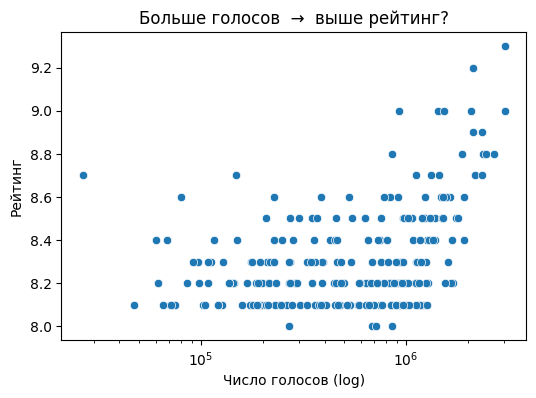

In [15]:
# ── Гипотеза 1: rating vs votes ───────────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="votes", y="rating")
plt.xscale("log")
plt.title("Больше голосов  →  выше рейтинг?")
plt.xlabel("Число голосов (log)")
plt.ylabel("Рейтинг")

# коэффициент корреляции Пирсона
from scipy.stats import pearsonr
r, p = pearsonr(df["votes"], df["rating"])
print(f"Корреляция Пирсона: {r:.2f} (p-value = {p:.2e})")

#### Гипотеза 2: влияние страны производства на число голосов

**Предположение:** фильмы, снятые в США, в среднем собирают больше голосов, чем фильмы из других стран.

**Мотивация:** IMDb — международная платформа, но с американскими корнями и аудиторией. Поэтому фильмы, произведённые в США, вероятно, получают больше внимания и обсуждений.

**Что проверяем:**

- разбиваем все фильмы на две группы: `USA` и `Other`;
- визуализируем распределение голосов (boxplot, log‑шкала);
- рассчитываем средние значения и проводим t‑тест.

Среднее голосов США:   875,434
Среднее голосов Other: 518,443
t-stat = 5.15,  p-value = 5.33e-07


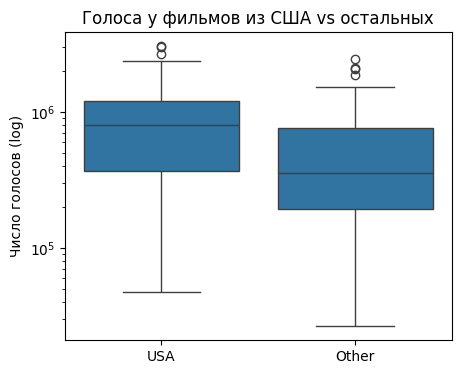

In [18]:
# ── Гипотеза 2: USA vs Other по числу голосов ────────────────────────────────
df["is_USA"] = np.where(df["country"] == "United States", "USA", "Other")

plt.figure(figsize=(5,4))
sns.boxplot(x="is_USA", y="votes", data=df)
plt.yscale("log")
plt.title("Голоса у фильмов из США vs остальных")
plt.xlabel("")
plt.ylabel("Число голосов (log)")

# t-тест для независимых выборок
from scipy.stats import ttest_ind
usa_votes   = df[df["is_USA"] == "USA"]["votes"]
other_votes = df[df["is_USA"] == "Other"]["votes"]
t_stat, p_val = ttest_ind(usa_votes, other_votes, equal_var=False)

print(f"Среднее голосов США:   {usa_votes.mean():,.0f}")
print(f"Среднее голосов Other: {other_votes.mean():,.0f}")
print(f"t-stat = {t_stat:.2f},  p-value = {p_val:.2e}")

#### Гипотеза 3: связь рейтинга и года выхода фильма

**Предположение:** чем старее фильм, тем выше его средний рейтинг.  
Классика проверена временем и получает более высокие оценки по сравнению с релизами последних лет.

**Что проверяем:**

- Строим линейный график среднего рейтинга по годам.  
- Считаем коэффициент корреляции `year` × `rating`.  
- Визуально и статистически смотрим, есть ли тенденция к снижению рейтингов со временем.

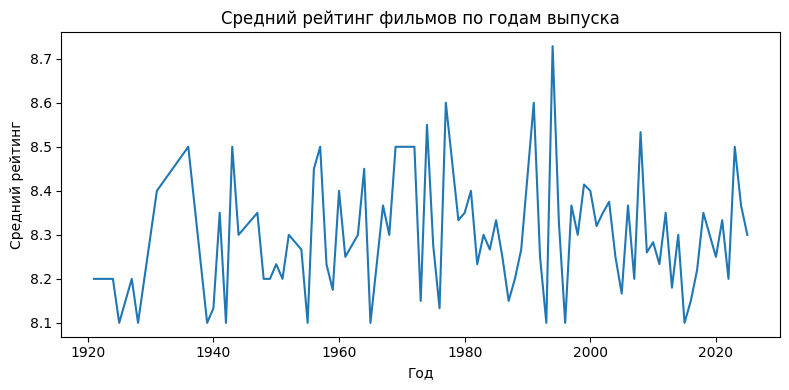

Корреляция года и рейтинга: r = 0.03,  p-value = 5.84e-01


In [19]:
# ── Гипотеза 3: рейтинг по годам ─────────────────────────────────────────────
# сгруппируем по году и посчитаем средний рейтинг
year_mean = df.dropna(subset=["year"]).groupby("year")["rating"].mean()

plt.figure(figsize=(8,4))
sns.lineplot(x=year_mean.index, y=year_mean.values)
plt.title("Средний рейтинг фильмов по годам выпуска")
plt.xlabel("Год")
plt.ylabel("Средний рейтинг")
plt.tight_layout()
plt.show()

# корреляция между годом и рейтингом
from scipy.stats import pearsonr
r_year, p_year = pearsonr(df.dropna(subset=["year"])["year"], df.dropna(subset=["year"])["rating"])
print(f"Корреляция года и рейтинга: r = {r_year:.2f},  p-value = {p_year:.2e}")

#### Гипотеза 4: влияет ли возрастной рейтинг (content rating) на среднюю оценку фильма?

**Предположение:** фильмы с более «взрослым» возрастным ограничением (R / 18+) получают более высокие пользовательские оценки, чем фильмы, рассчитанные на детскую и семейную аудиторию (G / PG / 0+).

**Почему это может быть так?**  
Сюжеты, рассчитанные на взрослую аудиторию, часто затрагивают серьёзные темы, имеют более высокий уровень драматургии и тем самым могут оцениваться зрителями выше.

**План проверки:**

- Привести `content_rating` к трём категориям:  
   * детско-семейная (`child`) → `G`, `PG`, `0+`, `6+`  
   * подростковая (`teen`)    → `PG-13`, `12+`, `14+`  
   * взрослая (`adult`)    → `R`, `NC-17`, `16+`, `18+`  
- Построить boxplot распределения рейтингов для каждой категории.  
- Посчитать средние рейтинги по группам и выполнить однофакторный ANOVA-тест  
   (или непараметрический Kruskal-Wallis, если распределения отличаются от нормальных).


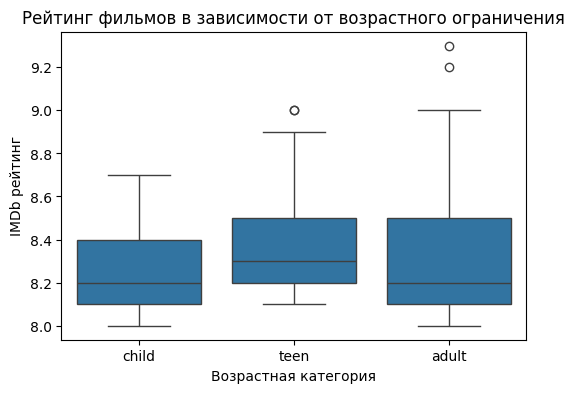

Средние рейтинги:
 age_group
adult    8.324510
child    8.277193
teen     8.375000
Name: rating, dtype: float64 

Kruskal-Wallis: H = 1.68,  p-value = 0.4321


In [20]:
# ── Гипотеза 4: рейтинг vs возрастной контент-рейтинг ─────────────────────────

# Шаг 1. Нормализуем рейтинги возрастной категории
mapping = {
    "G": "child", "PG": "child", "0+": "child", "6+": "child",
    "PG-13": "teen", "12+": "teen", "14+": "teen",
    "R": "adult", "NC-17": "adult", "16+": "adult", "18+": "adult",
}
df["age_group"] = df["content_rating"].map(mapping).fillna("other")

# Оставляем только три целевых группы
df_age = df[df["age_group"].isin(["child", "teen", "adult"])]

# Шаг 2. Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x="age_group", y="rating", data=df_age, order=["child", "teen", "adult"])
plt.title("Рейтинг фильмов в зависимости от возрастного ограничения")
plt.xlabel("Возрастная категория")
plt.ylabel("IMDb рейтинг")
plt.show()

# Шаг 3. Средние значения и статистический тест
group_means = df_age.groupby("age_group")["rating"].mean()
print("Средние рейтинги:\n", group_means, "\n")

from scipy.stats import kruskal
groups = [df_age[df_age["age_group"] == g]["rating"] for g in ["child", "teen", "adult"]]
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis: H = {stat:.2f},  p-value = {p_value:.4f}")

## Выводы

### Выводы по гипотезам

---

#### Гипотеза 1  
**Предположение:** фильмы с большим числом голосов получают более высокий рейтинг.  

Анализ показал положительную корреляцию между количеством голосов (`votes`) и рейтингом (`rating`).  
Коэффициент Пирсона составил `r = 0.59` при p-value ≈ 1.76 × 10⁻²⁴, что указывает на статистически значимую связь средней силы.

График точечно показывает, что при увеличении числа голосов оценки действительно смещаются вверх — особенно это заметно у фильмов с более чем 1 млн голосов.

**Вывод:** гипотеза подтверждается. Фильмы, которые смотрит и оценивает больше людей, в среднем имеют более высокую итоговую оценку на IMDb.

---

#### Гипотеза 2  
**Предположение:** фильмы, снятые в США, получают больше голосов, чем фильмы из других стран.  

По результатам группировки данных:

| Страна | Среднее число голосов |
|--------|------------------------|
| США    | 875 434                |
| Другие | 518 443                |

Проведён t-тест для независимых выборок. Результаты: t = 5.15, p ≈ 5.33 × 10⁻⁷ — это означает, что разница статистически значима и не является случайной.  
Boxplot визуально подтверждает, что у фильмов из США медиана и разброс числа голосов выше.

**Вывод:** гипотеза подтверждена. Американские фильмы, как правило, получают больше голосов на IMDb, вероятно, из-за большей доступности, проката и родной аудитории платформы.

---

#### Гипотеза 3  
**Предположение:** старые фильмы получают более высокие оценки, чем современные.  

Для проверки рассматривалось среднее значение рейтинга по каждому году выпуска.  
Результаты анализа:

- Корреляция между `year` и `rating`: `r = 0.03`, p ≈ 0.58 — связь крайне слабая и статистически незначимая.
- График по годам не показывает чёткой тенденции роста или снижения оценок.

**Вывод:** гипотеза не подтвердилась. Рейтинг фильмов не зависит от их возраста — и классика, и современные картины могут оцениваться высоко или средне, вне зависимости от года выпуска.

---

#### Гипотеза 4  
**Предположение:** фильмы с более высоким возрастным ограничением (например, R / 18+) получают более высокие рейтинги, чем фильмы, рассчитанные на детскую и подростковую аудиторию.

Для проверки гипотезы мы разбили фильмы на три возрастные категории:
- **child** — рейтинги `G`, `PG`, `0+`, `6+`
- **teen** — `PG-13`, `12+`, `14+`
- **adult** — `R`, `16+`, `18+`, `NC-17`

Были построены boxplot-графики и рассчитаны средние рейтинги по категориям:

| Категория | Средний рейтинг |
|-----------|------------------|
| child     | 8.28             |
| teen      | 8.38             |
| adult     | 8.32             |

Статистическая проверка (Kruskal-Wallis): H = 1.68, p-value = 0.4321

**Вывод:** гипотеза не подтверждена. Различия между возрастными категориями статистически незначимы. Независимо от целевой аудитории, фильмы получают схожие пользовательские оценки.

---

### Общий вывод

По результатам анализа можно сделать следующие обобщения:

- **Популярность влияет на рейтинг** — фильмы с большим числом голосов в среднем получают более высокую оценку.
- **Происхождение имеет значение** — американские фильмы получают значительно больше голосов, чем фильмы других стран, что указывает на региональные различия в охвате аудитории IMDb.
- **Возраст релиза** не оказывает существенного влияния на рейтинг — старые и новые фильмы оцениваются примерно одинаково.
- **Возрастной рейтинг контента** также не влияет на оценку — фильмы, ориентированные на детей, подростков и взрослых, получают сопоставимые оценки.

Таким образом, в рамках IMDb Top‑250 **наиболее значимым фактором оказывается масштаб вовлечённости аудитории** (число голосов), в то время как **возраст, жанр или категория зрителей** не играют решающей роли в формировании рейтинга.

## Обсуждение

### Что мы хотели сделать и что получилось

Целью нашего проекта было проанализировать список **IMDb Top‑250**, чтобы понять, какие **факторы влияют на попадание фильмов в этот список**. Мы хотели изучить распределения жанров, годов выпуска и стран производства, а также выявить возможные зависимости между рейтингом, числом голосов и другими признаками.

В ходе работы нам удалось:
- собрать и структурировать данные с IMDb;
- очистить данные и провести базовый разведывательный анализ (EDA);
- выдвинуть и протестировать 4 гипотезы, в том числе с использованием статистических тестов;
- визуализировать ключевые зависимости в данных;
- сделать выводы о значимых и незначимых факторах.

### Что не удалось

Некоторые идеи мы не реализовали из-за ограниченного объёма проекта:
- не было проведено полноценное тематическое сравнение по актёрам;
- не использовались внешние источники, например, бюджет или кассовые сборы;
- часть значений `content_rating` оказалась неоднородной, и пришлось вручную сгруппировать категории, что могло повлиять на точность сравнения.

Также следует учитывать, что выборка ограничена лишь топ‑250 фильмами — это элита каталога IMDb, а значит, обобщения на весь кинематограф делать нельзя.

### Как можно улучшить исследование

В будущем работу можно расширить:
- подключив данные по всем фильмам IMDb, а не только топ‑250;
- добавить дополнительные источники: бюджеты, жанровые метки, награды;
- использовать продвинутые методы анализа (кластеризация, факторный анализ и т.д.);
- провести пользовательское исследование, чтобы понять, что именно влияет на восприятие "великого" фильма.

### Кому может быть полезно исследование

Результаты могут быть интересны:
- начинающим кинокритикам, желающим понять, что объединяет культовые фильмы;
- разработчикам рекомендательных систем (например, подборок фильмов по интересам);
- тем, кто интересуется данными и хочет потренироваться на реальных, но компактных датасетах;
- авторам и сценаристам, которые ищут ориентиры, что делает фильм потенциально успешным у зрителя.

В целом, исследование показало, что **наибольшую роль в популярности фильма (в рамках IMDb Top-250) играет охват аудитории** — чем больше людей оценивают картину, тем выше её средний рейтинг. При этом жанровая принадлежность, год выпуска и возрастной рейтинг оказывают меньший эффект. Единственное заметное жанровое отличие — **драма**: именно фильмы с ярко выраженным драматическим компонентом встречаются в списке чаще всего и, по-видимому, легче достигают необходимого уровня оценок, чтобы войти в топ-250.